## Neuroendocrine tumor histology subtype prediction model

### Random Forest Classifier 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
# data = pd.read_csv("gene_data.csv", header = 0, index_col = 0)
data = pd.read_csv("gene_data_PDWD.tsv", sep ='\t', header = 0, index_col = 0)
data = data.T
data = np.log(data +1)
y = [ 0 if d.split('_')[1] == 'WD' else 1 for d in data.index ]

### Model learning and accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
    
    
# create a random forest classifier with 100 trees
rfc =  RandomForestClassifier(n_estimators=100, random_state = 2)

# fit the classifier to your data
rfc.fit(X_train, y_train)

# predict using the trained classifier
y_pred = rfc.predict(X_test)

print('Accuracy of RFC classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

Accuracy of RFC classifier on test set: 1.00


In [ ]:
confusion_matrix = confusion_matrix(y_pred, y_test)
print(confusion_matrix)

[[5 0]
 [0 3]]


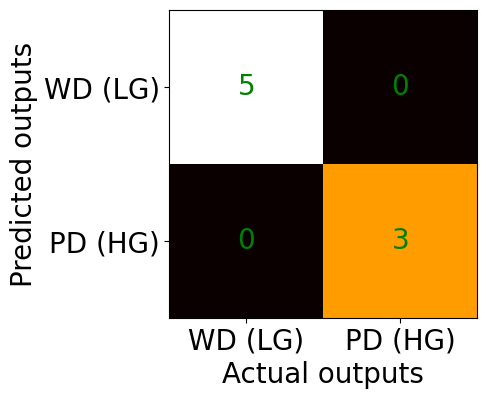

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(confusion_matrix, cmap='hot')
ax.grid(False)
ax.set_ylabel('Predicted outputs', fontsize=20, color='black')
ax.set_xlabel('Actual outputs', fontsize=20, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='green', fontsize=20)
ax.set_xticklabels(labels=["WD (LG)", "PD (HG)"], fontsize=20)
ax.set_yticklabels(labels=["WD (LG)", "PD (HG)"], fontsize=20)
plt.show()

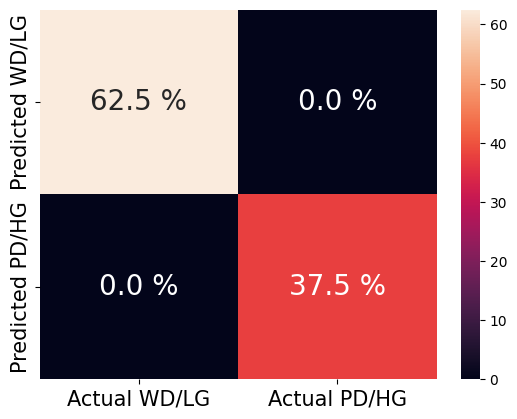

In [ ]:
import seaborn as sns
df = pd.DataFrame((confusion_matrix/8)*100, columns=['Actual WD/LG', 'Actual PD/HG'], index=['Predicted WD/LG', 'Predicted PD/HG'])
ax = sns.heatmap(df, annot=True, fmt=".1f", annot_kws={"size": 20})
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.savefig("confusion_matrix_rfc.png")
plt.show()

### 5-fold cross-validation

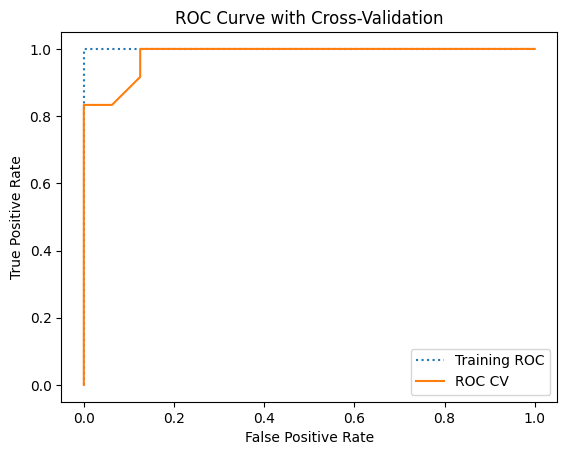

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Get the predicted probabilities for training and testing data
y_train_probs = rfc.predict_proba(X_train)[:, 1]
y_test_probs = rfc.predict_proba(X_test)[:, 1]

y_probs = cross_val_predict(rfc, X_train, y_train, method='predict_proba', cv=5)
y_probs = y_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_probs)

# Plot the ROC curve for the training data as a dotted line
plt.plot(fpr_train, tpr_train, linestyle='dotted', label='Training ROC')

plt.plot(fpr, tpr, label='ROC CV')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cross-Validation')
plt.legend()
plt.savefig("roc_curve_rfc.png")
plt.show()

### Gini importance 

In [ ]:
importances = rfc.feature_importances_

features = list(data.columns)

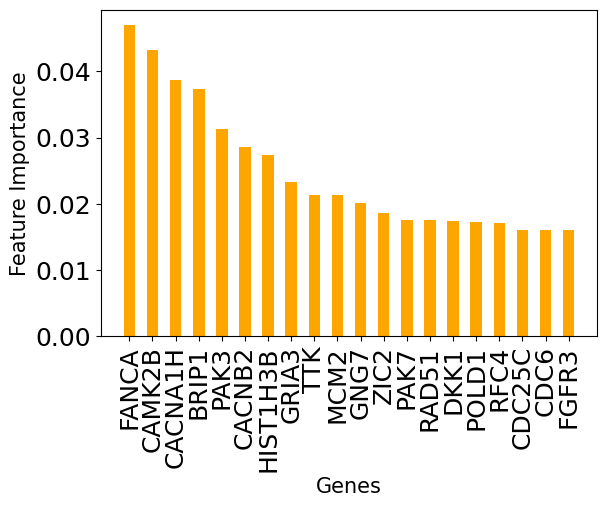

In [ ]:
sorted_genes_weights = sorted(zip(features, importances), key=lambda x: x[1])
n = 20

#lowest_genes = sorted_genes_weights[:n]
highest_genes = sorted_genes_weights[-n:]
highest_genes = highest_genes[::-1]

# Extract the gene names and weights for the plot
gene_features = [g[0] for g in highest_genes]
gene_weights = [g[1] for g in highest_genes]

bar_width = 0.5
plt.bar(gene_features, gene_weights, width=bar_width, color ='orange')

plt.xticks(rotation=90,fontsize=18)
plt.yticks(fontsize=18)


plt.xlabel('Genes', fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)
#plt.title('rfc Feature Importance')

plt.subplots_adjust(bottom=0.2)

plt.savefig("feature_importance_gini.png")
plt.show()

In [ ]:
highest_genes

[('FANCA', 0.04697076023391813),
 ('CAMK2B', 0.043289952153110045),
 ('CACNA1H', 0.03865384615384616),
 ('BRIP1', 0.03728129713423831),
 ('PAK3', 0.03133333333333333),
 ('CACNB2', 0.028666666666666667),
 ('HIST1H3B', 0.027320512820512823),
 ('GRIA3', 0.02336898395721925),
 ('TTK', 0.021414141414141413),
 ('MCM2', 0.021393471509570584),
 ('GNG7', 0.02012753036437247),
 ('ZIC2', 0.018585858585858584),
 ('PAK7', 0.0175),
 ('RAD51', 0.0175),
 ('DKK1', 0.017407407407407406),
 ('POLD1', 0.017334385272846812),
 ('RFC4', 0.01715376676986584),
 ('CDC25C', 0.01611111111111111),
 ('CDC6', 0.016085858585858585),
 ('FGFR3', 0.01603742690058479)]

### SHAP Analysis

In [ ]:
import shap

explainer = shap.TreeExplainer(rfc)
#explainer

/root/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/root/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

In [ ]:
shap_values = explainer.shap_values(X_test)
#shap_values

In [ ]:
#shap_values[0]
#shap_values[1]

In [ ]:
#np.array( shap_values )[0,:,data.columns.tolist().index('FANCA')]

In [ ]:
#X_test.index

In [ ]:
pd.DataFrame({'SHAP':np.array( shap_values )[0,:,data.columns.tolist().index('FANCA')]}, index = X_test.index)



,SHAP
SC15-615_PD,-0.030873
SO13-7742_WD,0.018308
SC14-3857_WD,0.016701
SC14-469_PD,-0.030873
SO13-7790_PD,-0.030873
SC14-3805_WD,0.018308
SC14-2414_WD,0.018308
SO11-5496_WD,-0.021136


In [ ]:
shap_imp = [  "{}:{:.4f}".format( i, j ) for i, j in (zip( X_test.columns, np.abs( shap_values[0] ).mean(0).round(2) )) ]

#shap_imp



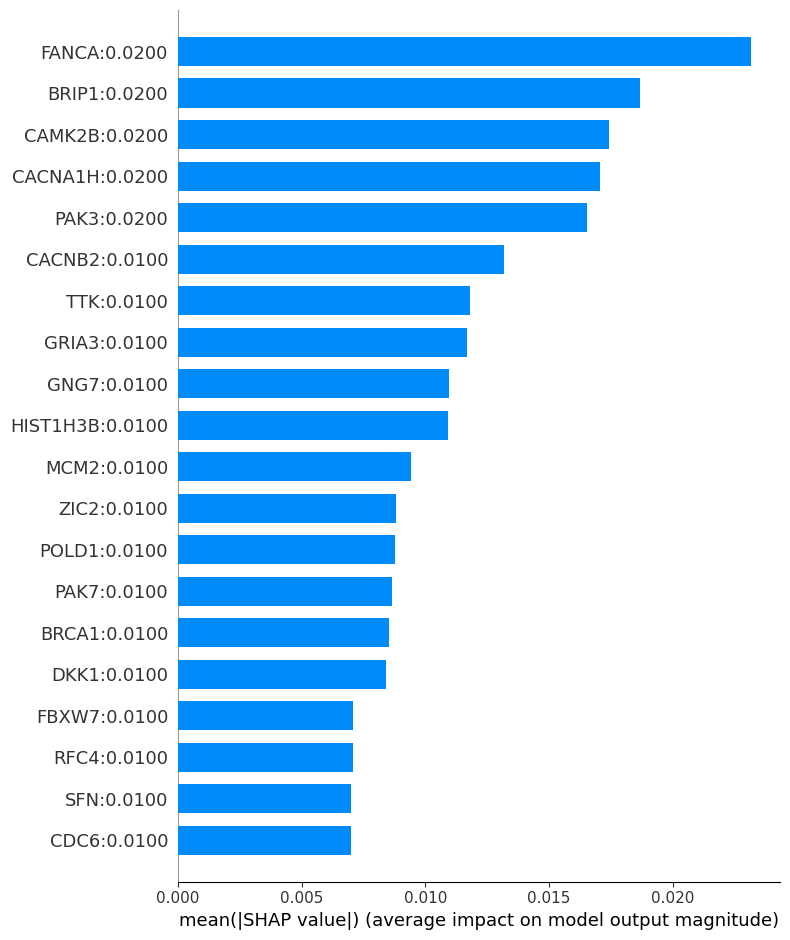

In [ ]:
shap.summary_plot(  shap_values[0], X_test, feature_names = shap_imp, max_display = 20, plot_type= 'bar' )

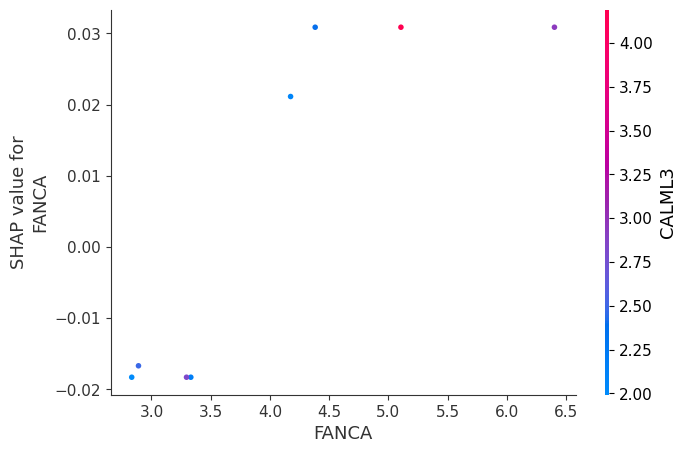

In [ ]:
shap.dependence_plot( 'FANCA', shap_values[1], X_test ) 

In [ ]:
sorted_genes_weights = sorted(zip(X_test.columns, shap_values[0].mean(0).round(5)), key=lambda x: x[1])

highest_genes = sorted_genes_weights[:10] + sorted_genes_weights[-10:]

gene_features = [g[0] for g in highest_genes]
gene_weights = [g[1] for g in highest_genes]

weights = pd.DataFrame(zip(gene_features, gene_weights), columns=["Gene","Feature Importance"])
weights
#sorted_genes_weights[-20:]

,Gene,Feature Importance
0,GNG7,-0.00559
1,TTK,-0.00529
2,FANCA,-0.00527
3,DNMT1,-0.00484
4,HIST1H3B,-0.00481
5,CDC6,-0.00322
6,WNT4,-0.00315
7,BRCA1,-0.00252
8,RPA3,-0.00239
9,SFN,-0.00221


### SHAP 0-WD importance

In [ ]:
DeepnoteChart(weights, spec_dict={
  "layer": [
    {
      "layer": [
        {
          "mark": {
            "clip": True,
            "type": "bar",
            "color": "#4b371c",
            "tooltip": True
          },
          "encoding": {
            "x": {
              "sort": None,
              "type": "nominal",
              "field": "Gene",
              "scale": {
                "type": "linear"
              }
            },
            "y": {
              "sort": None,
              "type": "quantitative",
              "field": "Feature Importance",
              "scale": {
                "type": "linear"
              },
              "format": {
                "type": "default",
                "decimals": None
              },
              "aggregate": "sum",
              "formatType": "numberFormatFromNumberType"
            },
            "opacity": {
              "condition": {
                "test": {
                  "and": [
                    {
                      "param": "legend_size_0"
                    },
                    {
                      "param": "legend_color_0"
                    },
                    {
                      "param": "interval_selection"
                    }
                  ]
                },
                "value": 1
              },
              "value": 0.2
            }
          },
          "params": [
            {
              "name": "legend_size_0",
              "select": {
                "type": "point",
                "encodings": [
                  "size"
                ],
                "toggle": "true"
              },
              "bind": "legend"
            },
            {
              "name": "legend_color_0",
              "select": {
                "type": "point",
                "encodings": [
                  "color"
                ],
                "toggle": "true"
              },
              "bind": "legend"
            },
            {
              "name": "interval_selection",
              "select": {
                "type": "interval",
                "encodings": [
                  "x",
                  "y"
                ]
              }
            }
          ]
        }
      ]
    }
  ],
  "title": "SHAP[0]",
  "config": {
    "legend": {
      "labelFont": "Arial",
      "labelFontSize": 18,
      "titleFont": "Arial",
      "titleFontSize": 18,
      "titleFontWeight": "bold"
    },
    "title": {
      "anchor": "start",
      "color": "#40566C",
      "font": "Arial",
      "fontSize": 20,
      "fontWeight": "bold",
      "dy": -16
    },
    "axis": {
      "labelFont": "Arial",
      "labelFontSize": 18,
      "labelFontWeight": "normal",
      "titleFont": "Arial",
      "titleFontSize": 18,
      "titleFontWeight": "bold",
      "labelOverlap": "parity"
    },
    "customFormatTypes": True
  },
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "encoding": {},
  "height": 481,
  "width": 600,
  "padding": 32,
  "autosize": {
    "type": "fit"
  }
})

In [ ]:
sorted_genes_weights = sorted(zip(X_test.columns, shap_values[1].mean(0).round(5)), key=lambda x: x[1])

highest_genes = sorted_genes_weights[:10] + sorted_genes_weights[-10:]

gene_features = [g[0] for g in highest_genes] #for g in sorted_genes_weights
gene_weights = [g[1] for g in highest_genes] 

weights = pd.DataFrame(zip(gene_features, gene_weights), columns=["Gene","Feature Importance"])

weights.to_csv('shap1_importance.csv', index=False)


weights

,Gene,Feature Importance
0,CAMK2B,-0.00580
1,PRL,-0.00394
2,BRIP1,-0.00346
3,CCNE1,-0.00321
4,PAK3,-0.00276
5,PAK7,-0.00275
6,DKK1,-0.00271
7,SETBP1,-0.00249
8,HOXA10,-0.00244
9,RFC4,-0.00235


In [ ]:
content_list = []
for index, row in weights.iterrows():
    content_list.append(f"('{row['Gene']}', {row['Feature Importance']})")
content_list

["('CAMK2B', -0.0058)",
 "('PRL', -0.00394)",
 "('BRIP1', -0.00346)",
 "('CCNE1', -0.00321)",
 "('PAK3', -0.00276)",
 "('PAK7', -0.00275)",
 "('DKK1', -0.00271)",
 "('SETBP1', -0.00249)",
 "('HOXA10', -0.00244)",
 "('RFC4', -0.00235)",
 "('SFN', 0.00221)",
 "('RPA3', 0.00239)",
 "('BRCA1', 0.00252)",
 "('WNT4', 0.00315)",
 "('CDC6', 0.00322)",
 "('HIST1H3B', 0.00481)",
 "('DNMT1', 0.00484)",
 "('FANCA', 0.00527)",
 "('TTK', 0.00529)",
 "('GNG7', 0.00559)"]

### SHAP 1-PD importance

In [ ]:
DeepnoteChart(weights, spec_dict={
  "layer": [
    {
      "layer": [
        {
          "mark": {
            "clip": True,
            "type": "bar",
            "color": "#54a24b",
            "tooltip": True
          },
          "encoding": {
            "x": {
              "sort": None,
              "type": "nominal",
              "field": "Gene",
              "scale": {
                "type": "linear"
              }
            },
            "y": {
              "sort": None,
              "type": "quantitative",
              "field": "Feature Importance",
              "scale": {
                "type": "linear"
              },
              "format": {
                "type": "default",
                "decimals": None
              },
              "aggregate": "sum",
              "formatType": "numberFormatFromNumberType"
            },
            "opacity": {
              "condition": {
                "test": {
                  "and": [
                    {
                      "param": "legend_size_0"
                    },
                    {
                      "param": "legend_color_0"
                    },
                    {
                      "param": "interval_selection"
                    }
                  ]
                },
                "value": 1
              },
              "value": 0.2
            }
          },
          "params": [
            {
              "name": "legend_size_0",
              "select": {
                "type": "point",
                "encodings": [
                  "size"
                ],
                "toggle": "true"
              },
              "bind": "legend"
            },
            {
              "name": "legend_color_0",
              "select": {
                "type": "point",
                "encodings": [
                  "color"
                ],
                "toggle": "true"
              },
              "bind": "legend"
            },
            {
              "name": "interval_selection",
              "select": {
                "type": "interval",
                "encodings": [
                  "x",
                  "y"
                ]
              }
            }
          ]
        }
      ]
    }
  ],
  "title": "SHAP[1]",
  "config": {
    "legend": {
      "labelFont": "Arial",
      "labelFontSize": 18,
      "titleFont": "Arial",
      "titleFontSize": 18,
      "titleFontWeight": "bold"
    },
    "title": {
      "anchor": "start",
      "color": "#40566C",
      "font": "Arial",
      "fontSize": 20,
      "fontWeight": "bold",
      "dy": -16
    },
    "axis": {
      "labelFont": "Arial",
      "labelFontSize": 20,
      "labelFontWeight": "normal",
      "titleFont": "Arial",
      "titleFontSize": 18,
      "titleFontWeight": "bold",
      "labelOverlap": "parity"
    },
    "customFormatTypes": True
  },
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "encoding": {},
  "height": 481,
  "width": 500,
  "padding": 20,
  "autosize": {
    "type": "fit"
  }
})

In [ ]:
#sorted_genes_weights

gene_features = [g[0] for g in sorted_genes_weights]
gene_weights = [g[1] for g in sorted_genes_weights]

df = pd.DataFrame(zip(gene_features, gene_weights), columns=["Gene","Feature Importance"])
df


,Gene,Feature Importance
0,CAMK2B,-0.00580
1,PRL,-0.00394
2,BRIP1,-0.00346
3,CCNE1,-0.00321
4,PAK3,-0.00276
...,...,...
779,HIST1H3B,0.00481
780,DNMT1,0.00484
781,FANCA,0.00527
782,TTK,0.00529


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26a52daa-3781-4303-b6d1-419771ff77cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>